In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import AUROC, Accuracy, ConfusionMatrix, F1Score
import os, subprocess, gc, time, datetime
from itertools import product

import models.models_original as models_original
import models.models_3d_atomics as models_3d_atomics
from vasopressor.preprocess_helpers import load_and_create_MIMIC_dataloader
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import greedy_forward_selection, get_top_features_per_concept

gpu_id = int(subprocess.check_output('nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader | nl -v 0 | sort -nrk 2 | cut -f 1 | head -n 1 | xargs', shell=True, text=True))
device = torch.device(f'cuda:{gpu_id}') if torch.cuda.is_available else torch.device('cpu')
print("current device", device)

current device cuda:14


In [2]:
train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = 1)

print(class_weights, num_classes, seq_len)

for batch in train_loader:
    [print(t.shape, t.device) for t in batch]
    break

len(train_loader)

tensor([0.5797, 3.6376], dtype=torch.float64) 2 6
torch.Size([512, 6, 27]) cpu
torch.Size([512, 6, 27]) cpu
torch.Size([512, 8]) cpu
torch.Size([512, 2]) cpu


35

In [3]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.yscale("log")
    plt.legend()
    plt.show()

def plot_metrics(history, n_concepts_list):
    plt.plot(history[:, 0], history[:, 2], label=f'AUC')
    plt.plot(history[:, 0], history[:, 3], label=f'ACC')
    plt.plot(history[:, 0], history[:, 4], label=f'F1')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title('Plot of Concepts vs Criteria')
    plt.xticks(n_concepts_list)

    plt.legend()
    plt.show()

def plot_atomics_concepts_metric(history, title, dec="{:.3g}"):
        
    df = pd.DataFrame(history, columns=["n_atomics", "n_concepts", "val_loss", "auc", "acc", "f1"])
    mean_atomics = df.groupby("n_atomics").mean()
    mean_concepts = df.groupby("n_concepts").mean()

    # display(mean_atomics)
    plt.plot(mean_atomics.index, mean_atomics["auc"], label='AUC')
    plt.plot(mean_atomics.index, mean_atomics["acc"], label='ACC')
    plt.plot(mean_atomics.index, mean_atomics["f1"], label='F1')
    plt.xlabel('Num Atomics')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over atomics")
    plt.suptitle(title)
    plt.legend()
    plt.show()

    # display(mean_concepts)
    plt.plot(mean_concepts.index, mean_concepts["auc"], label='AUC')
    plt.plot(mean_concepts.index, mean_concepts["acc"], label='ACC')
    plt.plot(mean_concepts.index, mean_concepts["f1"], label='F1')
    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over concepts")
    plt.suptitle(title)
    plt.legend()
    plt.show()


In [4]:
auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)
conf_matrix = ConfusionMatrix(task="binary").to(device)

seq_len = seq_len
changing_dim = len(changing_vars)
static_dim = len(static_names)

print(changing_dim, static_dim, seq_len)

random_seed = 1
set_seed(random_seed)


27 8 6


## Optimization

In [6]:
# feature weights
config_original = {
    "n_concepts": 4,
    "use_indicators": True,
    "use_only_last_timestep": False,
}

experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/original/"
model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_original.keys()]) + "seed_{seed}.pt"

train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

top_k = "" # "/workdir/optimal-summaries-public/_models/vasopressor/original/top-k/bottleneck_topkinds.csv"

model = models_original.CBM(**config_original, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2, top_k=top_k, device=device)
model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config_original, seed = random_seed), max_epochs=10000)

evaluate_classification(model, test_loader, num_classes=num_classes, device=device)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_use_indicators_True_use_only_last_timestep_False_seed_1.pt
AUC macro 0.9202549457550049
ACC macro 0.849922776222229
 F1 macro 0.8584378957748413


(0.9202549457550049, 0.849922776222229, 0.8584378957748413)

In [7]:
abs_bottleneck_weights = model.bottleneck.weight.cpu().detach().numpy()
abs_bottleneck_weights = np.abs(abs_bottleneck_weights)
abs_bottleneck_weights.shape


(4, 656)

In [8]:
threshold = 1e-4  # Threshold value

# Iterate over each row (dimension)
for row_idx in range(abs_bottleneck_weights.shape[0]):
    # Select weights bigger than the threshold for the current row
    selected_weights = abs_bottleneck_weights[row_idx][abs_bottleneck_weights[row_idx] < threshold]
    
    # Print the selected weights for the current row
    print(f"Row {row_idx + 1}: Selected weights smaller than threshold ({threshold}):")
    # print(selected_weights)
    print(len(selected_weights))


Row 1: Selected weights smaller than threshold (0.0001):
89
Row 2: Selected weights smaller than threshold (0.0001):
46
Row 3: Selected weights smaller than threshold (0.0001):
43
Row 4: Selected weights smaller than threshold (0.0001):
50


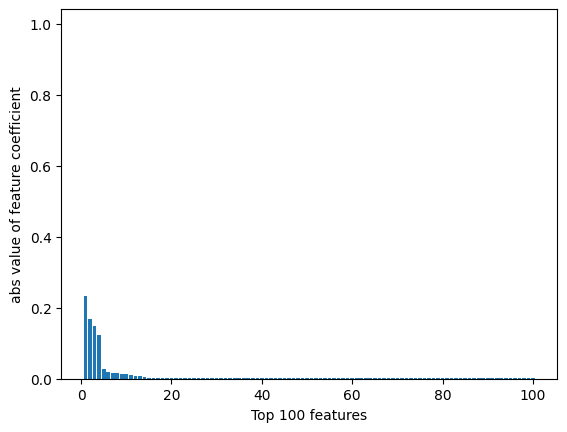

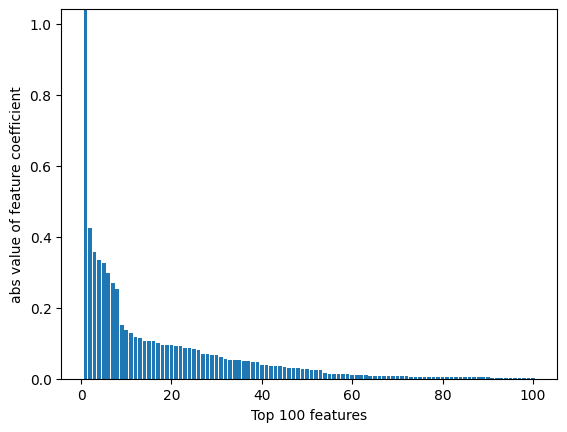

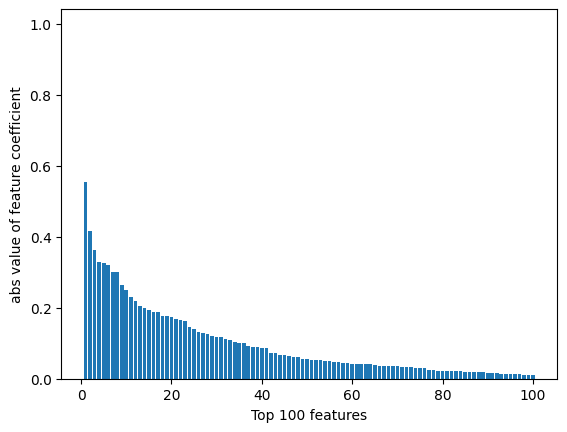

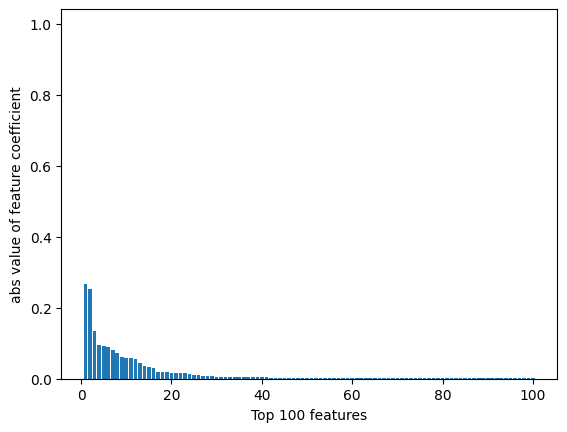

In [25]:
visualize_top100_weights_per_channel(model.bottleneck)


In [10]:
top_k_inds = get_top_features_per_concept(model.bottleneck)
# top_k_inds
model.linear.weight

Found 4 Concepts
90th percentile per concept [1.0566624 6.3947773 9.681674  1.997804 ]
['Concept 0 len: 224', 'Concept 1 len: 55', 'Concept 2 len: 83', 'Concept 3 len: 202']


Parameter containing:
tensor([[ 0.9464,  2.1869,  3.0792, -1.1883],
        [-0.7421, -2.0947, -3.1212,  1.9510]], device='cuda:14',
       requires_grad=True)

In [ ]:
# write top k inds to csv
top_k_file = experiment_folder + "top-k/top_k_idx.csv"

directory = os.path.dirname(top_k_file)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(top_k_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
V = 13 + 1
T = seq_len + 1
print(T)
vars_ = [i for i in range(1,V)] + [str(i) + "_ind" for i in range(1,V)]
print(len(vars_))
data_cols = [["feat_{}_time_{}".format(v, t) for v in vars_] for t in range(1, T)]
flattened_data_cols = [col for sublist in data_cols for col in sublist]
print(len(flattened_data_cols))
flattened_data_cols

In [ ]:

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


In [11]:
track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               "auc": auroc_metric,
               }

greedy_results = greedy_forward_selection(model=model, layers_to_prune=[model.bottleneck], top_k_inds=[top_k_inds], val_loader=val_loader, optimize_metric=auroc_metric, device=device, track_metrics=track_metrics)


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [3:34:56<00:00, 322.42s/it, Score=0.92721, acc=0.86, f1=0.865, auc=0.927]   


In [26]:
pd.set_option('display.max_rows', 100)
greedy_results

,Score,Layer,Concept,Feature,acc,f1,auc
0,0.903700,0,2,537,0.828844,0.842852,0.903700
1,0.913109,0,1,626,0.866507,0.868336,0.913109
2,0.915173,0,2,76,0.867021,0.868933,0.915173
3,0.916330,0,1,265,0.867708,0.869100,0.916330
4,0.917185,0,1,133,0.867450,0.868990,0.917185
5,0.918063,0,1,123,0.867450,0.869300,0.918063
6,0.919156,0,3,376,0.860501,0.865531,0.919156
7,0.920338,0,2,622,0.853209,0.861109,0.920338
8,0.920885,0,2,175,0.857155,0.863581,0.920885
9,0.921402,0,2,42,0.856040,0.862908,0.921402


In [27]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_topkinds.csv" #_r{}_c{}   .format(random_seed, n_concepts)

import csv
# writing to csv file
with open(top_k_csv_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(greedy_results.columns)
    # writing the data rows 
    for row in greedy_results.itertuples(index=False):
        csvwriter.writerow(list(row))


In [ ]:
sorted_ = greedy_results.sort_values(["Concept", "ID"])

for row in sorted_.itertuples(index=False):
    name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, row[1])
    print(f"Concept {row[2]}: ID {row[1]}, Feature {name}, Summary {summary}")

In [ ]:
plt.plot(greedy_results["Score"], label = f"AUC {greedy_results['Score'].values[-1]:.3f}")
plt.plot(greedy_results["acc"], label = f"ACC {greedy_results['acc'].values[-1]:.3f}")

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')

plt.legend()
plt.show()


In [ ]:
top_k_csv_file = "/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/bottleneck_r1_c6_topkinds.csv"
n_concepts = 6
model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes, top_k=top_k_csv_file)
# model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()

print(auc)
print(acc)


In [ ]:
model.fit(train_loader, val_loader, class_weights, save_model_path="/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/arabic_c6_finetuned.pt", max_epochs=3000, patience=100)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model(Xb)
        
        auc = auroc_metric(probs, yb)
        acc = accuracy_metric(probs, yb)
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
print(auc)
print(acc)


In [ ]:

plt.plot(model.val_losses)
plt.show()

## Optimization Atomics

In [5]:
experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/atomics_new/"

def get_model(random_seed):
    # feature weights
    config_atomics = {
        "n_atomics": 10, # 30
        "n_concepts": 4, # 20
        "use_indicators": True,
        "use_summaries_for_atomics": True,
    }

    model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_atomics.keys()]) + "seed_{seed}.pt"

    train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

    top_k = "" # "/workdir/optimal-summaries-public/_models/vasopressor/atomics/top-k/bottleneck_topkinds.csv"

    model = models_3d_atomics.CBM(**config_atomics, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2, top_k=top_k, device=device)
    model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config_atomics, seed = random_seed), max_epochs=10000)

    evaluate_classification(model, test_loader, num_classes=num_classes, device=device)
    return model

model = get_model(2)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics_new/n_atomics_10_n_concepts_4_use_indicators_True_use_summaries_for_atomics_True_seed_2.pt
AUC macro 0.9185908436775208
ACC macro 0.840140700340271
 F1 macro 0.8484256863594055


In [6]:
top_k_inds = [get_top_features_per_concept(layer) for layer in model.regularized_layers]
# top_k_inds
model.layer_output.weight

Found 10 Concepts
90th percentile per concept [0.13140249 0.4425258  0.10969655 2.8915112  0.15215701 4.4262614
 0.49244112 0.11314931 0.15070061 0.12636156]
['Concept 0 len: 10', 'Concept 1 len: 10', 'Concept 2 len: 10', 'Concept 3 len: 10', 'Concept 4 len: 10', 'Concept 5 len: 11', 'Concept 6 len: 10', 'Concept 7 len: 10', 'Concept 8 len: 10', 'Concept 9 len: 10']
Found 4 Concepts
90th percentile per concept [ 0.14386193  0.17527968  0.18341854 11.166749  ]
['Concept 0 len: 133', 'Concept 1 len: 128', 'Concept 2 len: 134', 'Concept 3 len: 28']


Parameter containing:
tensor([[-0.3209, -1.0140, -0.5046,  6.4994],
        [ 0.5147,  0.5977,  1.0961, -6.4349]], device='cuda:14',
       requires_grad=True)

In [7]:
auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)

track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               "auc": auroc_metric,
               }

greedy_results_atomics = greedy_forward_selection(model=model, layers_to_prune=model.regularized_layers, top_k_inds=top_k_inds, val_loader=val_loader, optimize_metric=auroc_metric, device=device, track_metrics=track_metrics)
greedy_results_atomics


  0%|          | 0/140 [00:00<?, ?it/s]

100%|██████████| 140/140 [7:31:16<00:00, 193.40s/it, Score=0.92666, acc=0.861, f1=0.866, auc=0.924]  


,Score,Layer,Concept,Feature,acc,f1,auc
0,0.905987,0,3,27,0.137440,0.137440,0.137440
1,0.911362,0,3,30,0.137440,0.137440,0.137440
2,0.912489,0,6,16,0.137440,0.137440,0.137440
3,0.912918,0,6,24,0.137440,0.137440,0.137440
4,0.913316,0,1,21,0.137440,0.137440,0.137440
...,...,...,...,...,...,...,...
135,0.926657,1,0,260,0.861445,0.865875,0.924052
136,0.926657,1,0,112,0.861445,0.865875,0.924052
137,0.926657,1,0,82,0.861445,0.865875,0.924052
138,0.926657,1,1,151,0.861445,0.865875,0.924052


In [8]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_topkinds_{}.csv".format(2)

write_df_2_csv(top_k_csv_file, greedy_results_atomics)